<a href="https://colab.research.google.com/github/harshitbansal184507/Machine-Learning/blob/main/alzheimerdetect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

Dataset URL: https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images
License(s): ODbL-1.0
100% 34.0M/34.1M [00:01<00:00, 28.7MB/s]
100% 34.1M/34.1M [00:01<00:00, 21.0MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("alzheimers-dataset-4-class-of-images.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
categories = ['MildDemented', 'VeryMildDemented', 'NonDemented', 'ModerateDemented']


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
train_dataset_path = '/content/Alzheimer_s Dataset/train'
validation_dataset_path = '/content/Alzheimer_s Dataset/test'

In [ ]:
import pandas as pd

In [ ]:
def preprocess_images(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image=image.astype(np.float32)/255.0
    return image

train_images = []
train_labels = []
test_images = []
test_labels = []
directories = os.listdir('Alzheimer_s Dataset')

# Load training data
train_directory = 'Alzheimer_s Dataset/train'
for class_name in os.listdir(train_directory):
    class_path = os.path.join(train_directory, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        image = preprocess_images(image_path)
        train_images.append(image)
        train_labels.append(class_name)

test_directory = 'Alzheimer_s Dataset/test'
for class_name in os.listdir(test_directory):
    class_path = os.path.join(test_directory, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        image = preprocess_images(image_path)
        test_images.append(image)
        test_labels.append(class_name)

train_images_nparr = np.array(train_images)
train_labels_nparr = np.array(train_labels)
test_images_nparr = np.array(test_images)
test_labels_nparr = np.array(test_labels)

print("Training Images shape:", train_images_nparr.shape)
print("Training Labels shape:", train_labels_nparr.shape)
print("Test Images shape:", test_images_nparr.shape)
print("Test Labels shape:", test_labels_nparr.shape)

Training Images shape: (5121, 208, 176, 3)
Training Labels shape: (5121,)
Test Images shape: (1279, 208, 176, 3)
Test Labels shape: (1279,)


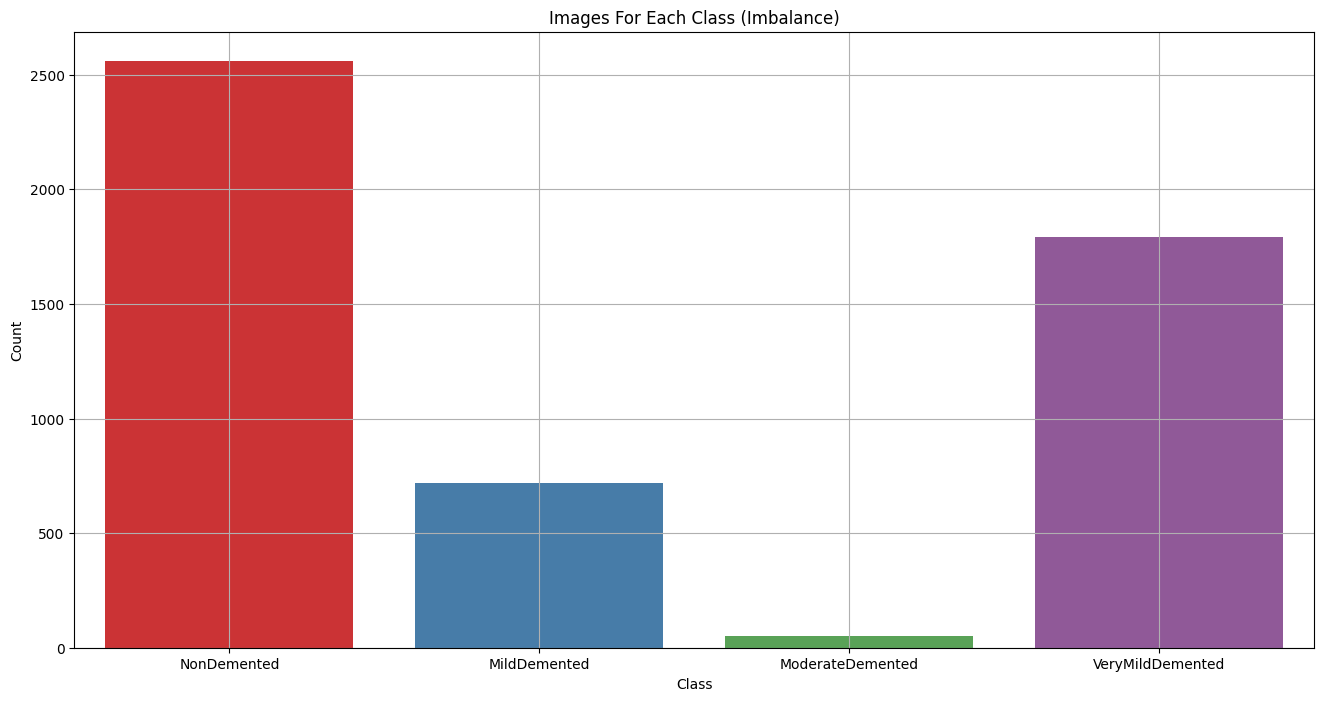

In [ ]:
plt.figure(figsize=(16,8))
ax = sns.countplot(x=train_labels_nparr,palette='Set1')
ax.set_xlabel("Class")
ax.set_ylabel("Count")
plt.title('Images For Each Class (Imbalance)')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels_nparr), y=train_labels_nparr)
class_weight_dict = dict(zip(np.unique(train_labels_nparr), class_weights))

print("Class weights:", class_weight_dict)

Class weights: {'MildDemented': 1.7855648535564854, 'ModerateDemented': 24.620192307692307, 'NonDemented': 0.50009765625, 'VeryMildDemented': 0.7144252232142857}


In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.8, 1.2],
    zoom_range=0.2,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [51]:
train_generator = datagen.flow_from_directory(
    train_directory,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    test_directory,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [61]:
x_batch, y_batch = next(validation_generator)
print(x_batch,y_batch)

[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0

In [62]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')  # 4 classes
])

In [63]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [65]:
model.fit(train_generator,
          validation_data=validation_generator,
          steps_per_epoch=len(train_generator),
          validation_steps=len(validation_generator),
          epochs=30,
          )

Epoch 1/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 35s 204ms/step - accuracy: 0.5598 - loss: 0.9157 - val_accuracy: 0.5004 - val_loss: 4.2590
Epoch 2/30


AttributeError: 'NoneType' object has no attribute 'items'